In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as reading
import matplotlib.pyplot as plt
import seaborn as graph 
import plotly.express as px 
from warnings import filterwarnings as filt 
import cv2
import os
filt('ignore')
plt.style.use('dark_background')

In [3]:
%%capture
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from tensorflow.keras.utils import plot_model as draw

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time

In [4]:
base_path = "/content/drive/MyDrive/DATA_SET"

In [5]:
def obtaining_data(Location):
    features = {
        'img_path' : [],
        'target'   : [],
    }
    for U in os.listdir(Location):
        P = [os.path.join(U, i) for i in os.listdir(os.path.join(Location, U))]
        features['img_path'] += P
        features['target']   += [U] * len(P)
        
    print(f'length of image path : {len(features["img_path"])}')
    print(f'length of target     : {len(features["target"])}')
    return features

In [6]:
data = obtaining_data(base_path)
df = reading.DataFrame(data)
df.head()

length of image path : 10655
length of target     : 10655


,img_path,target
0,benign/melanoma_4605.jpg,benign
1,benign/melanoma_4598.jpg,benign
2,benign/melanoma_4603.jpg,benign
3,benign/melanoma_4595.jpg,benign
4,benign/melanoma_4593.jpg,benign


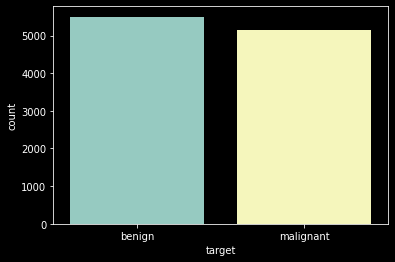

In [7]:
graph.countplot(df.target);

In [8]:
import albumentations as album
from keras.preprocessing.image import ImageDataGenerator as data_production
import tensorflow.keras.utils as utils

In [9]:
from sklearn.model_selection import train_test_split as separate

In [10]:
def create_data_gen(df, base_path, image, label, data_gen_args = {}, **kwargs):
    production = data_production(**data_gen_args)
    getting_data = production.flow_from_dataframe(df, base_path, x_col = image, y_col = label, **kwargs)
    return getting_data

In [11]:
def dividing(image, label, frac = 0.2, return_val = True):
    x,xt, y, yt = separate(image, label, test_size = frac, stratify = label)
    instruct = reading.concat([x, y], axis = 1)
    verify = reading.concat([xt, yt], axis = 1)
    if return_val:
        return instruct, verify
    return instruct

In [12]:
image = df.drop(['target'], axis = 1)
label = df.target

instruct_df, verify_df = dividing(image, label, 0.15)

assess_df, verify_df = dividing(verify_df.drop(['target'], axis = 1), verify_df.target, 0.5)
instruct_df.shape

(9056, 2)

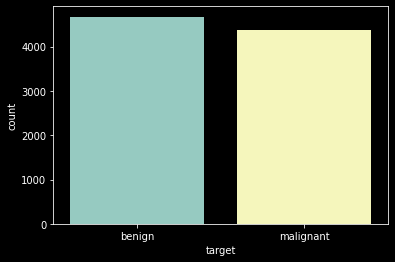

In [13]:
graph.countplot(instruct_df.target)

In [14]:
def transforms(image, normalize = True):
    transform = album.Compose([
        album.HorizontalFlip(),
        album.VerticalFlip(),
        album.CenterCrop(250 ,250, p = 0.4),
        album.GaussianBlur(p = 0.5),
        album.OneOf([
            album.Rotate(limit = 70, border_mode = cv2.BORDER_CONSTANT),
            album.Rotate(limit = 50, border_mode = cv2.BORDER_CONSTANT),
            album.Rotate(limit = 120, border_mode = cv2.BORDER_CONSTANT),
        ], p = 1),
        album.Resize(300, 300)
    ])
    
    x = transform(image = image)['image']
    if normalize:
        x = x / 255
    return x

In [15]:
t_dargs = {
    'preprocessing_function' : transforms
}

v_dargs = {
    'preprocessing_function' : lambda x : x / 255
}

instruct_loader = create_data_gen(instruct_df, base_path, 'img_path', 'target', t_dargs, batch_size = 64, 
                               color_mode = 'rgb', class_mode = 'categorical', target_size = (300, 300), shuffle = True)

verify_loader = create_data_gen(verify_df, base_path, 'img_path', 'target', v_dargs, batch_size = 64, 
                               color_mode = 'rgb', class_mode = 'categorical', target_size = (300, 300), shuffle = False)

assess_loader = create_data_gen(assess_df, base_path, 'img_path', 'target', v_dargs, batch_size = 64, 
                               color_mode = 'rgb', class_mode = 'categorical', target_size = (300, 300), shuffle = False)

Found 9056 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Found 799 validated image filenames belonging to 2 classes.


In [16]:
def mobilenet(input_shape, categorize):
  
  def mobilenet_block(layer, f, s=1):
    layer = DepthwiseConv2D(3, strides=s, padding='same')(layer)
    layer = BatchNormalization()(layer)
    layer = ReLU()(layer)
    
    layer = Conv2D(f, 1, strides=1, padding='same')(layer)
    layer = BatchNormalization()(layer)
    layer = ReLU()(layer)
    return layer
    
    
  input = Input(input_shape)

  layer = Conv2D(32, 3, strides=2, padding='same')(input)
  layer = BatchNormalization()(layer)
  layer = ReLU()(layer)

  layer = mobilenet_block(layer, 64)
  layer = mobilenet_block(layer, 128, 2)
  layer = mobilenet_block(layer, 128)

  layer = mobilenet_block(layer, 256, 2)
  layer = mobilenet_block(layer, 256)

  layer = mobilenet_block(layer, 512, 2)
  for U in range(3): # Instead of 5 We have given 3
    layer = mobilenet_block(layer, 512)

  layer = mobilenet_block(layer, 1024, 2)
  layer = mobilenet_block(layer, 1024)
  
  layer = GlobalAvgPool2D()(layer)

  layer = drop(rate=0.1)(layer)
  
  output = Dense(categorize, activation='softmax')(layer)
  
  model = Model(input, output)
  return model

In [17]:
from tensorflow.keras.layers import Dropout as drop
IMG_SHAPE = (300, 300, 3)
categorize = 2
custom_make = mobilenet(IMG_SHAPE, categorize)

In [18]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 2, mode = 'min', verbose = 1)
checkpoint = ModelCheckpoint('model.h5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')

In [19]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
import tensorflow as tf

custom_make.compile(optimizer = tf.keras.optimizers.Adam(),loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [20]:
#custom_make.summary()

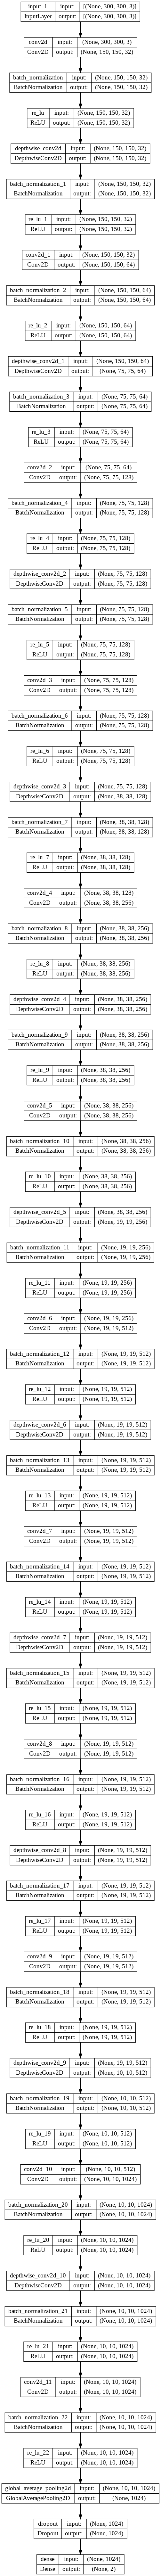

In [21]:
draw(custom_make,show_shapes = True)

In [27]:
epoch = 10
archive = custom_make.fit_generator(instruct_loader, epochs = epoch, callbacks = [reduce_lr, checkpoint], validation_data = verify_loader)

Epoch 1/10
142/142 [==============================] - ETA: 0s - loss: 0.2156 - accuracy: 0.9103
Epoch 1: val_loss did not improve from 0.21017
142/142 [==============================] - 104s 731ms/step - loss: 0.2156 - accuracy: 0.9103 - val_loss: 0.2106 - val_accuracy: 0.9062 - lr: 1.0000e-05
Epoch 2/10
142/142 [==============================] - ETA: 0s - loss: 0.2194 - accuracy: 0.9090
Epoch 2: val_loss did not improve from 0.21017
142/142 [==============================] - 104s 729ms/step - loss: 0.2194 - accuracy: 0.9090 - val_loss: 0.2110 - val_accuracy: 0.9038 - lr: 1.0000e-05
Epoch 3/10
142/142 [==============================] - ETA: 0s - loss: 0.2146 - accuracy: 0.9119
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 3: val_loss did not improve from 0.21017
142/142 [==============================] - 100s 702ms/step - loss: 0.2146 - accuracy: 0.9119 - val_loss: 0.2120 - val_accuracy: 0.9050 - lr: 1.0000e-05
Epoch 4/10
142/142 [=================

In [28]:
custom_make.evaluate_generator(assess_loader)

[0.24725213646888733, 0.8986232876777649]

In [29]:
from sklearn.metrics import classification_report as report
from sklearn.metrics import confusion_matrix as mat

def get_detailed(custom_make, loader):
    presage = custom_make.predict_generator(loader)
    presage  = np.argmax(presage, axis = 1)
    original = loader.classes
    print(report(original, presage))
    print()
    line = plt.subplot()
    graph.heatmap(mat(original, presage), fmt = 'd', annot = True)
    line.set_xlabel('Predicted labels');line.set_ylabel('True labels'); 
    line.set_title('Confusion Matrix'); 
    line.xaxis.set_ticklabels(['benign', 'malignant']); 
    line.yaxis.set_ticklabels(['benign', 'malignant']);

              precision    recall  f1-score   support

           0       0.87      0.94      0.91       412
           1       0.93      0.85      0.89       387

    accuracy                           0.90       799
   macro avg       0.90      0.90      0.90       799
weighted avg       0.90      0.90      0.90       799




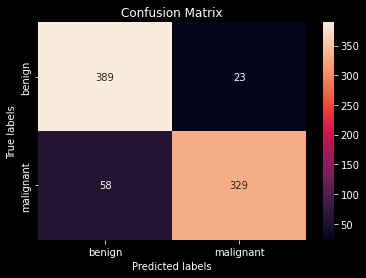

In [30]:
get_detailed(custom_make, assess_loader)

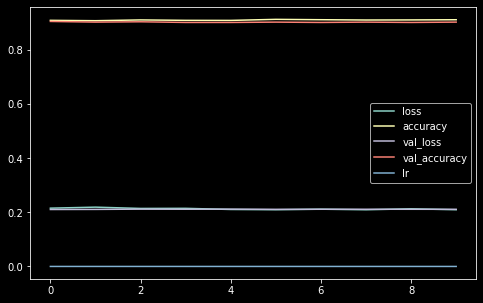

In [31]:
reading.DataFrame(archive.history).plot(figsize=(8,5))
plt.show()